# Direct Regression from Images to Travel Behavior Variables

In [1]:
from setup import out_dir, data_dir, image_dir, model_dir
%load_ext autoreload
%autoreload 2

import os
from datetime import datetime
import json
from collections import OrderedDict
import logging
import numpy as np
import random
import matplotlib.pyplot as plt
plt.rcParams.update({"font.size":14})
%matplotlib inline
import glob
import pandas as pd
import time 

import torch
import torch.nn as nn
import torch.optim
import torch.utils.data
import torch.backends.cudnn
import torchvision.utils
import torchvision.transforms
import torch.nn.functional as F

try:
    from tensorboardX import SummaryWriter
    is_tensorboard_available = True
except Exception:
    is_tensorboard_available = False

from dataloader import image_loader_DR, load_demo
from util_model import load_model, AverageMeter

torch.backends.cudnn.benchmark = True

logging.basicConfig(
    format='[%(asctime)s %(name)s %(levelname)s] - %(message)s',
    datefmt='%Y/%m/%d %H:%M:%S',
    level=logging.DEBUG)
logger = logging.getLogger(__name__)

global_step = 0

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

[2022/02/04 10:29:52 matplotlib.backends DEBUG] - backend module://ipykernel.pylab.backend_inline version unknown


In [2]:
zoomlevel = 'zoom13'
output_dim = 1
model_run_date = "22020302"
model_type = "DR"
model_code = "BA1"
variable_names = ['active','auto','mas','pt','trpgen']

demo_variables = ['tot_population','pct25_34yrs','pct35_50yrs','pctover65yrs',
         'pctwhite_alone','pct_nonwhite','pctblack_alone',
         'pct_col_grad','avg_tt_to_work','inc_per_capita']

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")

In [3]:
args = {'image_size': 224, 
        'depth': -1,
        'dropout':0,
        'n_alts': 4,
       'base_channels':64,
       'output_dim':output_dim,
       'cardinality':1,
       'epochs':200,
       'batch_size':4,
       'base_lr':0.005,
       'weight_decay':0.05,
       'momentum': 0.9,
       'nesterov': True,
       'milestones': '[50,100]',
       'lr_decay':0.1,
       'seed': 1234,
       'outdir':out_dir,
       'num_workers':8,
       'tensorboard':False,
       'save':True}

model_config = OrderedDict([
    ('arch', 'resnext'),
    ('depth', args['depth']),
    ('base_channels', args['base_channels']),
    ('cardinality', args['cardinality']),
    ('input_shape', (1, 3, 32, 32)),
    ('output_dim', args['output_dim']),
    ('n_alts', 4),
    ('dropout', args['dropout'])
])

optim_config = OrderedDict([
    ('epochs', args['epochs']),
    ('batch_size', args['batch_size']),
    ('base_lr', args['base_lr']),
    ('weight_decay', args['weight_decay']),
    ('momentum', args['momentum']),
    ('nesterov', args['nesterov']),
    ('milestones', json.loads(args['milestones'])),
    ('lr_decay', args['lr_decay']),
])

data_config = OrderedDict([
    ('dataset', 'CIFAR10'),
    ('image_size', args['image_size'])
])

run_config = OrderedDict([
    ('seed', args['seed']),
    ('outdir', args['outdir']),
    ('save', args['save']),
    ('num_workers', args['num_workers']),
    ('tensorboard', args['tensorboard']),
])

config = OrderedDict([
    ('model_config', model_config),
    ('optim_config', optim_config),
    ('data_config', data_config),
    ('run_config', run_config),
])

In [4]:
# parse command line arguments
#config = parse_args()
#logger.info(json.dumps(config, indent=2))

model_name = datetime.now().strftime("%m%d-%H%M")

run_config = config['run_config']
optim_config = config['optim_config']

# TensorBoard SummaryWriter
writer = SummaryWriter(model_name) if run_config['tensorboard'] else None

# set random seed
seed = run_config['seed']
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [5]:
# data loaders
train_loader, test_loader = image_loader_DR(image_dir+zoomlevel+"/", data_dir, optim_config['batch_size'], 
                                         run_config['num_workers'], 
                                         data_config['image_size'], 
                                         target=['active','auto','mas','pt'], 
                                         recalculate_normalize=False, num_images_per_tract=5)

[2022/02/04 10:29:52 numexpr.utils INFO] - Note: NumExpr detected 20 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
[2022/02/04 10:29:52 numexpr.utils INFO] - NumExpr defaulting to 8 threads.


In [6]:
criterion = nn.KLDivLoss(reduction='batchmean')


In [7]:
# model
config['model_config']['input_shape'] = (1,3,data_config['image_size'],data_config['image_size'])

encoder = load_model(config['model_config']['arch'], 'Encoder', config['model_config'])
encoder = encoder.to(device)    

config['encoder'] = encoder
model = load_model('direct_regression','DirectRegression', config)
model = model.to(device)

optimizer = torch.optim.SGD(
    model.parameters(),
    lr=optim_config['base_lr'],
    momentum=optim_config['momentum'],
    weight_decay=optim_config['weight_decay'],
    nesterov=optim_config['nesterov'])

scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer,
    milestones=optim_config['milestones'],
    gamma=optim_config['lr_decay'])

In [8]:
ref1 = 0
ref2 = 0

train_loss_list = []
test_loss_list = []

for epoch in range(optim_config['epochs']):

    model.train()

    loss_meter = AverageMeter()
    start = time.time()

    for step, (batch_im, batch_y) in enumerate(train_loader):

        batch_im = batch_im.to(device)
        batch_y = batch_y.to(device)
        optimizer.zero_grad()

        out = model(batch_im)
        probs = torch.log(nn.functional.softmax(out, dim=1))
        
        loss = criterion(probs, batch_y)
        loss.backward()

        optimizer.step()
        scheduler.step()
       
        loss_ = loss.item()
        loss_meter.update(loss_, len(batch_y))

#         print(loss_)
    if logger is not None:
        if epoch % 5 == 0:
            logger.info('Epoch {} Train KL Loss {:.8f}'.format(epoch, loss_meter.avg))

    train_loss_list.append(loss_meter.avg)
   
    if epoch % 5 == 0:

        model.eval()
        loss_meter = AverageMeter()
        
        for step, (batch_im, batch_y) in enumerate(test_loader):
            batch_im = batch_im.to(device)
            batch_y = batch_y.to(device)

            out = model(batch_im)
            probs = torch.log(nn.functional.softmax(out, dim=1))

            loss = criterion(probs, batch_y)

            loss_ = loss.item()
            loss_meter.update(loss_, len(batch_y))

        test_loss_list.append(loss_meter.avg)

        if logger is not None:
            logger.info('Epoch {} Test KL Loss {:.8f}'.format(epoch, loss_meter.avg))
            elapsed = time.time() - start
        
        if epoch > 50:
            if (np.abs(loss_ - ref1)/ref1<ref1*0.01) & (np.abs(loss_ - ref2)/ref2<ref2*0.01):
                print("Early stopping at epoch", epoch)
                break
            if (ref1 < loss_) & (ref1 < ref2):
                print("Diverging. stop.")
                break
            if loss_ < best:
                best = loss_
                best_epoch = epoch
        else:
            best = loss_
            best_epoch = epoch

        ref2 = ref1
        ref1 = loss_

        if (config['run_config']['save']) & (best_epoch==epoch):
            torch.save({'epoch': epoch,
                'config': config,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()},
                model_dir+model_type+"_"+zoomlevel+"_"+str(model_config['output_dim']**2*2048)+"_"+model_run_date+"_"+str(epoch)+".pt")

            files = glob.glob(model_dir+model_type+"_"+zoomlevel+"_"+str(model_config['output_dim']**2*2048)+"_"+model_run_date+"_*.pt")


if config['run_config']['save']:
    for f in files:
        e = int(f.split("_")[-1].split(".")[0])
        if e != best_epoch:
            os.remove(f)

[2022/02/04 10:30:17 __main__ INFO] - Epoch 0 Train KL Loss 0.85927105
[2022/02/04 10:30:18 __main__ INFO] - Epoch 0 Test KL Loss 0.42376703
[2022/02/04 10:32:00 __main__ INFO] - Epoch 5 Train KL Loss 0.28740903
[2022/02/04 10:32:02 __main__ INFO] - Epoch 5 Test KL Loss 0.37071819
[2022/02/04 10:33:44 __main__ INFO] - Epoch 10 Train KL Loss 0.27494198
[2022/02/04 10:33:45 __main__ INFO] - Epoch 10 Test KL Loss 0.41265852
[2022/02/04 10:35:27 __main__ INFO] - Epoch 15 Train KL Loss 0.26543853
[2022/02/04 10:35:28 __main__ INFO] - Epoch 15 Test KL Loss 0.36228224
[2022/02/04 10:37:10 __main__ INFO] - Epoch 20 Train KL Loss 0.25802151
[2022/02/04 10:37:11 __main__ INFO] - Epoch 20 Test KL Loss 0.38554389
[2022/02/04 10:38:53 __main__ INFO] - Epoch 25 Train KL Loss 0.25352258
[2022/02/04 10:38:54 __main__ INFO] - Epoch 25 Test KL Loss 0.36928905
[2022/02/04 10:40:36 __main__ INFO] - Epoch 30 Train KL Loss 0.24666461
[2022/02/04 10:40:37 __main__ INFO] - Epoch 30 Test KL Loss 0.32961550
[20

Diverging. stop.


In [9]:
# Check one model exists for this config
model_path = glob.glob(model_dir+model_type+"_"+zoomlevel+"_"+str(model_config['output_dim']**2*2048)+"_"+
                       model_run_date+"_*.pt")
#
if len(model_path) == 1:
    saved = torch.load(model_path[0])
    print(model_path[0], "loaded.")
else:
    print("Error. More than one model or no model exists.")
    print(model_path)
    print(model_dir+model_type+"_"+zoomlevel+"_"+str(model_config['output_dim']**2*2048)+"_"
                      +model_run_date+"_*.pt")
    
model.load_state_dict(saved['model_state_dict']);
model = model.to(device)

/dream/qingyi/image_chicago/models/DR_zoom13_2048_22020302_65.pt loaded.


In [10]:
loss_meter = AverageMeter()

train_y = []
train_predict = []
for step, (batch_im, batch_y) in enumerate(train_loader):
    
    batch_im = batch_im.to(device)
    batch_y = batch_y.to(device)

    out = model(batch_im)
    probs = torch.log(nn.functional.softmax(out, dim=1))

    loss = criterion(probs, batch_y)
    loss_ = loss.item()
    
    loss_meter.update(loss_, len(batch_y))
    
    train_y.append(batch_y.detach().cpu().numpy())
    train_predict.append(torch.exp(probs).detach().cpu().numpy())

train_loss = loss_meter.avg
train_y = np.vstack(train_y)
train_predict = np.vstack(train_predict)

train_r1 = r2_score(train_y[:,0],train_predict[:,0])
train_r2 = r2_score(train_y[:,1],train_predict[:,1])
train_r3 = r2_score(train_y[:,2],train_predict[:,2])
train_r4 = r2_score(train_y[:,3],train_predict[:,3])

train_mse1 = np.sqrt(mean_squared_error(train_y[:,0],train_predict[:,0]))
train_mse2 = np.sqrt(mean_squared_error(train_y[:,1],train_predict[:,1]))
train_mse3 = np.sqrt(mean_squared_error(train_y[:,2],train_predict[:,2]))
train_mse4 = np.sqrt(mean_squared_error(train_y[:,3],train_predict[:,3]))

print(train_r1, train_r2, train_r3, train_r4, train_mse1, train_mse2, train_mse3, train_mse4)

-0.07085918162289029 -0.11190269803495312 -0.12475860473406564 -2.530142482205385 0.18076526 0.25398752 0.055099096 0.15516736


In [11]:
test_y = []
test_predict = []
loss_meter = AverageMeter()

for step, (batch_im, batch_y) in enumerate(test_loader):
    
    batch_im = batch_im.to(device)
    batch_y = batch_y.to(device)

    out = model(batch_im)
    probs = torch.log(nn.functional.softmax(out, dim=1))

    loss = criterion(probs, batch_y)
    loss_ = loss.item()
    
    loss_meter.update(loss_, len(batch_y))
    
    test_y.append(batch_y.detach().cpu().numpy())
    test_predict.append(torch.exp(probs).detach().cpu().numpy())
    
test_loss = loss_meter.avg
test_y = np.vstack(test_y)
test_predict = np.vstack(test_predict)

test_r1 = r2_score(test_y[:,0],test_predict[:,0])
test_r2 = r2_score(test_y[:,1],test_predict[:,1])
test_r3 = r2_score(test_y[:,2],test_predict[:,2])
test_r4 = r2_score(test_y[:,3],test_predict[:,3])

test_mse1 = np.sqrt(mean_squared_error(test_y[:,0],test_predict[:,0]))
test_mse2 = np.sqrt(mean_squared_error(test_y[:,1],test_predict[:,1]))
test_mse3 = np.sqrt(mean_squared_error(test_y[:,2],test_predict[:,2]))
test_mse4 = np.sqrt(mean_squared_error(test_y[:,3],test_predict[:,3]))

print(test_r1, test_r2, test_r3, test_r4, test_mse1, test_mse2, test_mse3, test_mse4)

-0.2304997215916631 -0.3098957588510416 -0.40766793738747187 -1.5524368964059145 0.19654116 0.28497478 0.043930948 0.1604814


In [12]:
with open(out_dir+model_code+"_mode_choice.csv", "a") as f:
    f.write("%s,%s,%s,%.4f,%.5f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f\n" % \
        (model_run_date, model_type, zoomlevel, args['base_lr'], args['weight_decay'], 
          train_loss, train_mse1, train_mse2, train_mse3, train_mse4, train_r1, train_r2, train_r3, train_r4,
          test_loss, test_mse1, test_mse2, test_mse3, test_mse4,
          test_r1, test_r2, test_r3, test_r4))

[2022/02/04 10:54:28 matplotlib.font_manager DEBUG] - findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=14.0 to DejaVu Sans ('/home/jtl/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


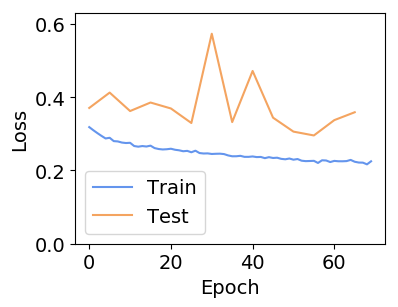

In [13]:
fig, ax = plt.subplots(figsize=(4,3))
ax.plot(train_loss_list[1:], color='cornflowerblue', label='Train')
ax.plot(np.arange(0,best_epoch+1,5), test_loss_list[1:], color='sandybrown', label='Test')
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_ylim([0, 1.1*np.max(train_loss_list[1:]+test_loss_list[1:])])
ax.legend()
plt.show()
fig.savefig(out_dir+"training_plots/DR_"+model_run_date+".png", bbox_inches='tight')